# TENNIS PREDICTOR

## 1. Data Importing and Preprocessing

### 1.1 Importing Data 
- Go through all csv files and merge all games since 1989 in one big Pandas Dataframe.
- Rename columns with better names.

In [143]:
# imports .
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get data file names
path = r'./data/atp_matches'
all_files = glob.glob(path + "/*.csv")


start_year_considered = 1989

tournament_old_new_columns = {
    "tourney_name": "Tourney",
    "surface": "Surface",
    "tourney_date": "Date", 
    "winner_name": "Player1", 
    "winner_age": "Player1Age", 
    "winner_ioc": "Player1Nationality",
    "loser_name": "Player2", 
    "loser_age": "Player2Age",
    "loser_ioc": "Player2Nationality",
    "score": "Score",
    "best_of": "BestOf",
    "minutes": "MinutesPlayed"
}

df_tournaments = pd.DataFrame([])

for filename in all_files:
    start_year = filename.split("/")[-1].split("_")[-1].split(".")[0]
    if int(start_year) > start_year_considered: 
        df = pd.read_csv(filename, index_col = None)        
        df_tournaments = pd.concat([df_tournaments, df])

df_tournaments = df_tournaments[tournament_old_new_columns.keys()]
df_tournaments.rename(columns = tournament_old_new_columns, inplace = True)


### 1.2 Preprocessing

- Format Date column as a DateTime object.
- Sort rows by dates (older to newest)
- Drop games from exibition tournaments (Davis Cup and Laver Cup)
- Create Target column "Player1Won" (the value that we will try to predict)

In [144]:
# PREPROCESSING
# Format Date as DateTime.
df_tournaments["Date"] = df_tournaments["Date"].apply(
    lambda x: str(x)[0:4] + "-" + str(x)[4:6] + "-" + str(x)[6:]
)
df_tournaments['Date'] =  pd.to_datetime(df_tournaments['Date'])

# Set MinutesPlayed = NaN to placeholder value of 0.0 
df_tournaments["MinutesPlayed"] = df_tournaments["MinutesPlayed"].fillna(0.0)

# Sort by Date, Reset Index and drop Na and Davis/Laver Cup
df_tournaments = df_tournaments.sort_values(by = "Date").dropna()
df_tournaments = df_tournaments[~(df_tournaments.Tourney.str.contains("Davis"))]
df_tournaments = df_tournaments[~(df_tournaments.Tourney.str.contains("Laver"))]

# Create target column
df_tournaments["Player1Won"] = 1.0

- Use Geocoders to get country from tournament name
- Make new Columns "Location" that specifies country in which the tournament is played

In [145]:
from geopy.geocoders import Nominatim

## INITIALISE ONLY WHEN RERUNNING FROM SCRATCH
# tournament_to_country_dict = {}
#############################################

# Dictionary of Countries 
for tournament in df_tournaments.Tourney.unique():
           
    if tournament in tournament_to_country_dict:
        continue
    if "Cup" in tournament or "Finals" in tournament:
        tournament_to_country_dict[tournament] = "International"
    
    else: 
        t = tournament.replace("Masters", "").replace("ATP", "").replace("Indoor", "")\
                      .replace("Outdoor", "").replace("Olympics", "").replace("Open", "")
        geolocator = Nominatim(user_agent = "tennis_predictor")
        location = geolocator.geocode(t, language = "en")

        country = location.address.split(",")[-1]
        tournament_to_country_dict[tournament] = country


In [146]:
# Standardize Locations to Countries
df_tournaments["Location"] = df_tournaments["Tourney"].apply(lambda x: tournament_to_country_dict[x])

- Make dictionary of IOC to IOS codes
- Use CountryConverter to convert players' Nationalities in countries

In [147]:
import country_converter as coco

ioc_to_ios = {"ALG": "DZA", "ANG": "AGO", "ANT": "ATG", "ARU": "ABW",
    "BAH": "BHS", "BRN": "BHR", "BAN": "BGD", "BAR": "BRB", "BIZ": "BLZ", "BER": "BMU", "BHU": "BTN", "BOT": "BWA",
    "IVB": "VGB", "BRU": "BRN", "BUL": "BGR", "BUR": "BFA", "CAM": "KHM", "CAY": "CYM", "CHA": "TCD", "CHI": "CHL",
    "CGO": "COG", "CRC": "CRI", "CRO": "HRV", "DEN": "DNK", "ESA": "SLV", "GEQ": "GNQ", "FIJ": "FJI", "GAM": "GMB",
    "GER": "DEU", "GRE": "GRC", "GRN": "GRD", "GUA": "GTM", "GUI": "GIN", "GBS": "GNB", "HAI": "HTI", "HON": "HND", 
    "INA": "IDN", "IRI": "IRN", "KUW": "KWT", "LAT": "LVA", "LIB": "LBN", "LES": "LSO", "LBA": "LBY", "MAD": "MDG", 
    "MAW": "MWI", "MAS": "MYS", "MTN": "MRT", "MRI": "MUS", "MON": "MCO", "MGL": "MNG", "MYA": "MMR", "NEP": "NPL", 
    "NED": "NLD", "NCA": "NIC", "NIG": "NER", "NGR": "NGA", "OMA": "OMN", "PLE": "PSE", "PAR": "PRY", "PHI": "PHL", 
    "POR": "PRT", "PUR": "PRI", "SKN": "KNA", "VIN": "VCT", "SAM": "WSM", "KSA": "SAU", "SEY": "SYC", "SIN": "SGP", 
    "SLO": "SVN", "SOL": "SLB", "RSA": "ZAF", "SRI": "LKA", "SUD": "SDN", "SUI": "CHE", "TPE": "TWN", "TAN": "TZA", 
    "TOG": "TGO", "TGA": "TON", "TRI": "TTO", "UAE": "ARE", "ISV": "VIR", "URU": "URY", "VAN": "VUT", "VIE": "VNM", 
    "YUG": "SRB","ZAM": "ZMB", "ZIM": "ZWE"
}

In [148]:
coco_converter = coco.CountryConverter()

df_tournaments["Player1Nationality"] = df_tournaments["Player1Nationality"].apply( \
    lambda x: ioc_to_ios[x] if x in ioc_to_ios else x \
)

df_tournaments["Player1Nationality"] = \
    coco_converter.convert(
        names = df_tournaments["Player1Nationality"].to_numpy(), to = "name_short"
    )

df_tournaments["Player2Nationality"] = df_tournaments["Player2Nationality"].apply( \
    lambda x: ioc_to_ios[x] if x in ioc_to_ios else x \
)

df_tournaments["Player2Nationality"] = \
    coco_converter.convert(
        names = df_tournaments["Player2Nationality"].to_numpy(), to = "name_short"
    )


- Custom-define function to parse the score (disregard anything containing alphabetic characters)
- Compute four new columns for games and sets won and lost by player 1.
- Compute two new binary columns to flag if player1 and player2 respectively are playing in their home country

In [149]:
def parseScore(score):
    sets_won = 0
    sets_lost = 0
    games_won = 0
    games_lost = 0
    
    sets = score.split(" ")
    for s in sets:
        if not(s):
            break
        games = s.split("-")
        
        games_p1 = games[0]
        games_p2 = games[1][0:2] if len(games[1]) and games[1].isnumeric() > 1 else games[1][0]
        
        if not games_p1.isnumeric() or not games_p2.isnumeric():
            break
        
        games_won += int(games_p1)
        games_lost += int(games_p2)
        if games_p1 > games_p2:
            sets_won += 1
        else:
            sets_lost += 1
    return [sets_won, sets_lost, games_won, games_lost]

In [150]:
# Remove retirements and walk overs
df_tournaments = df_tournaments[~df_tournaments.Score.str.contains(r'[a-zA-Z]')]


# Parse Scores in Games Won, Games Lost, Sets Won, Sets Lost
df_tournaments["Player1SetsWon"] = df_tournaments["Score"].apply( \
    lambda x: parseScore(x)[0]
)
df_tournaments["Player1SetsLost"] = df_tournaments["Score"].apply( \
    lambda x: parseScore(x)[1]                                                       
)
df_tournaments["Player1GamesWon"] = df_tournaments["Score"].apply( \
    lambda x: parseScore(x)[2]
)
df_tournaments["Player1GamesLost"] = df_tournaments["Score"].apply( \
    lambda x: parseScore(x)[3]                                                       
)

In [151]:
df_tournaments["Player1PlaysHome"] = \
    df_tournaments["Player1Nationality"] == df_tournaments["Location"]
df_tournaments["Player2PlaysHome"] = \
    df_tournaments["Player2Nationality"] == df_tournaments["Location"]

## Predict Minutes Played if were NaN

In [152]:
columns_to_use = ["Surface", "BestOf", "Player1SetsWon", "Player1SetsLost", 
                  "Player1GamesWon", "Player1GamesLost", "MinutesPlayed"]


df_tmp = pd.get_dummies(df_tournaments.copy()[columns_to_use])
df_no_minutes = df_tmp[df_tmp["MinutesPlayed"] == 0.0]
df_with_minutes = df_tmp[df_tmp["MinutesPlayed"] != 0.0]

In [153]:
x_train = df_with_minutes.drop(columns = ["MinutesPlayed"])
y_train = df_with_minutes["MinutesPlayed"]

x_test = df_no_minutes.drop(columns = ["MinutesPlayed"])

In [154]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter = 500).fit(x_train, y_train)

/home/fabio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [155]:
min_predicted = clf.predict(x_test)

df_no_minutes["MinutesPlayed"] = min_predicted
df_tournaments["MinutesPlayed"].iloc[df_no_minutes.index] = df_no_minutes.iloc[df_no_minutes.index]["MinutesPlayed"]

display(df_tournaments.iloc[df_no_minutes.index])

<ipython-input-155-a7732673b0c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_minutes["MinutesPlayed"] = min_predicted
<ipython-input-155-a7732673b0c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tournaments["MinutesPlayed"].iloc[df_no_minutes.index] = df_no_minutes.iloc[df_no_minutes.index]["MinutesPlayed"]


,Tourney,Surface,Date,Player1,Player1Age,Player1Nationality,Player2,Player2Age,Player2Nationality,Score,BestOf,MinutesPlayed,Player1Won,Location,Player1SetsWon,Player1SetsLost,Player1GamesWon,Player1GamesLost,Player1PlaysHome,Player2PlaysHome
13,Adelaide,Hard,1990-01-01,Jerome Potier,27.4,France,Slobodan Zivojinovic,26.4,Serbia,6-3 6-4,3,72.0,1.0,Australia,2,0,12,7,False,False
28,Adelaide,Hard,1990-01-01,Thomas Muster,22.2,Austria,Sergi Bruguera,18.9,Spain,2-6 6-2 7-6,3,111.0,1.0,Australia,2,1,15,14,False,False
0,Adelaide,Hard,1990-01-01,Sergi Bruguera,18.9,Spain,Per Henricsson,20.3,Sweden,7-6 6-2,3,82.0,1.0,Australia,2,0,13,8,False,False
1,Adelaide,Hard,1990-01-01,Broderick Dyke,29.0,Australia,Gary Muller,25.0,South Africa,6-4 6-4,3,80.0,1.0,Australia,2,0,12,8,False,False
2,Adelaide,Hard,1990-01-01,Michael Stich,21.2,Germany,Nicklas Kroon,23.9,Sweden,6-4 6-3,3,72.0,1.0,Australia,2,0,12,7,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,Rome Masters,Clay,1990-05-14,Paolo Cane,25.0,Italy,Federico Mordegan,20.2,Italy,4-6 7-5 6-2,3,125.0,1.0,Italy,2,1,17,13,False,False
1529,Rome Masters,Clay,1990-05-14,Jaime Yzaga,22.5,Peru,Javier Sanchez,22.2,Spain,6-4 4-6 6-4,3,122.0,1.0,Italy,2,1,16,14,False,False
1528,Rome Masters,Clay,1990-05-14,Jim Courier,19.7,United States,Franco Davin,20.3,Argentina,6-1 1-6 6-4,3,111.0,1.0,Italy,2,1,13,11,False,False
1527,Rome Masters,Clay,1990-05-14,Alberto Mancini,20.9,Argentina,Christian Miniussi,22.8,Argentina,4-6 7-6 6-4,3,140.0,1.0,Italy,2,1,17,16,False,False


- Reorder columns for easier readability
- Drop score column
- Randomly select 50% of the rows and swap data for player1 and player2
- For these rows, the target column also has to be changed to 0, instead of 1.

In [156]:
## Order Columns and restructure like this:
# winner = player1
# loser = player2
# shuffle winner-loser if rand(0, 1) > 0.5
# create a target Player1Won that is 1 if player1 won, 0 if they lost.
# drop score column, not needed anymore

columns_final_order = ["Date", "Tourney", "Location", "Surface", "BestOf", "MinutesPlayed",
                       "Player1", "Player1Age", "Player1Nationality", "Player1PlaysHome",
                       "Player2", "Player2Age", "Player2Nationality", "Player2PlaysHome",
                       "Player1SetsWon", "Player1SetsLost", "Player1GamesWon", 
                       "Player1GamesLost", "Player1Won"]

df_tournaments = df_tournaments.reset_index()[columns_final_order]

In [157]:
# swap 50% of the players to balance dataset.
random_indexes = np.array(df_tournaments.sample(frac = 0.50, axis = 'rows').index)

pairs_cols_toswap = [[6, 10], [7, 11], [8, 12], [9, 13], [14, 15], [16, 17]]
for pair in pairs_cols_toswap:
    tmp = df_tournaments.iloc[random_indexes, pair[0]].copy()
    df_tournaments.iloc[random_indexes, pair[0]] = df_tournaments.iloc[random_indexes, pair[1]]
    df_tournaments.iloc[random_indexes, pair[1]] = tmp

# Player 1 when swapped lost
df_tournaments.iloc[random_indexes, 18] = 0.0

### 1.3 Data Exporting
- Display final dataset
- Export dataset in CSV for immediate future use.

In [158]:
## UNCOMMENT ONLY WHEN NEEDING TO RERUN THE WHOLE PREPROCESSING ##
# df_tournaments.to_csv("data/processed_data.csv", index = False)
display(df_tournaments)

,Date,Tourney,Location,Surface,BestOf,MinutesPlayed,Player1,Player1Age,Player1Nationality,Player1PlaysHome,Player2,Player2Age,Player2Nationality,Player2PlaysHome,Player1SetsWon,Player1SetsLost,Player1GamesWon,Player1GamesLost,Player1Won
0,1990-01-01,Wellington,New Zealand,Hard,3,131.0,Thomas Hogstedt,26.2,Sweden,False,Shuzo Matsuoka,22.1,Japan,False,2,1,18,15,1.0
1,1990-01-01,Wellington,New Zealand,Hard,3,89.0,Brett Steven,20.6,New Zealand,False,Lars Jonsson,19.5,Sweden,False,0,2,9,13,0.0
2,1990-01-01,Wellington,New Zealand,Hard,3,77.0,Olivier Delaitre,22.5,France,False,Richard Fromberg,19.6,Australia,False,0,2,7,13,0.0
3,1990-01-01,Wellington,New Zealand,Hard,3,111.0,Jens Woehrmann,22.3,Germany,False,Paul Chamberlin,27.7,United States,False,1,2,10,18,0.0
4,1990-01-01,Wellington,New Zealand,Hard,3,75.0,Magnus Gustafsson,22.9,Sweden,False,Gilad Bloom,22.8,Israel,False,0,2,6,13,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92776,2022-08-29,Us Open,United States,Hard,5,94.0,Grigor Dimitrov,31.2,Bulgaria,False,Steve Johnson,32.6,United States,True,3,0,18,7,1.0
92777,2022-08-29,Us Open,United States,Hard,5,276.0,David Goffin,31.7,Belgium,False,Lorenzo Musetti,20.4,Italy,False,2,3,27,26,0.0
92778,2022-08-29,Us Open,United States,Hard,5,119.0,Gijs Brouwer,26.4,Netherlands,False,Adrian Mannarino,34.1,France,False,3,0,18,11,1.0
92779,2022-08-29,Us Open,United States,Hard,5,131.0,Daniil Medvedev,26.5,Russia,False,Arthur Rinderknech,27.1,France,False,3,0,19,10,1.0


## 2 Glicko2 Score

In [60]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt


### 2.1 Preprocessed Data Import

In [61]:
processed_df = pd.read_csv("data/processed_data.csv", index_col = None) 
processed_df["Surface"] = processed_df["Surface"].apply(
    lambda x: "Hard" if x == "Carpet" else x
)

curr_tourney = ""
curr_start_date = None
start_dates = []

for i, row in tqdm(processed_df.iterrows()):
    if curr_tourney != row["Tourney"]:
        curr_start_date = row["Date"]
        curr_tourney = row["Tourney"]
    start_dates.append(curr_start_date)
        
processed_df["StartDate"] = start_dates

processed_df = processed_df.sort_values(by = ["StartDate", "Tourney"])

display(processed_df)

92781it [00:03, 25734.29it/s]


,Date,Tourney,Location,Surface,BestOf,MinutesPlayed,Player1,Player1Age,Player1Nationality,Player1PlaysHome,Player2,Player2Age,Player2Nationality,Player2PlaysHome,Player1SetsWon,Player1SetsLost,Player1GamesWon,Player1GamesLost,Player1Won,StartDate
30,1990-01-01,Adelaide,Australia,Hard,3,111.0,Jimmy Arias,25.3,United States,False,Thomas Muster,22.2,Austria,False,1,2,13,16,0.0,1990-01-01
32,1990-01-01,Adelaide,Australia,Hard,3,111.0,Thomas Muster,22.2,Austria,False,Sergi Bruguera,18.9,Spain,False,2,1,15,14,1.0,1990-01-01
33,1990-01-01,Adelaide,Australia,Hard,3,82.0,Sergi Bruguera,18.9,Spain,False,Per Henricsson,20.3,Sweden,False,2,0,13,8,1.0,1990-01-01
34,1990-01-01,Adelaide,Australia,Hard,3,80.0,Gary Muller,25.0,South Africa,False,Broderick Dyke,29.0,Australia,False,0,2,8,12,0.0,1990-01-01
35,1990-01-01,Adelaide,Australia,Hard,3,72.0,Nicklas Kroon,23.9,Sweden,False,Michael Stich,21.2,Germany,False,0,2,7,12,0.0,1990-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92776,2022-08-29,Us Open,United States,Hard,5,94.0,Grigor Dimitrov,31.2,Bulgaria,False,Steve Johnson,32.6,United States,True,3,0,18,7,1.0,2022-08-29
92777,2022-08-29,Us Open,United States,Hard,5,276.0,Lorenzo Musetti,20.4,Italy,False,David Goffin,31.7,Belgium,False,3,2,26,27,1.0,2022-08-29
92778,2022-08-29,Us Open,United States,Hard,5,119.0,Gijs Brouwer,26.4,Netherlands,False,Adrian Mannarino,34.1,France,False,3,0,18,11,1.0,2022-08-29
92779,2022-08-29,Us Open,United States,Hard,5,131.0,Arthur Rinderknech,27.1,France,False,Daniil Medvedev,26.5,Russia,False,0,3,10,19,0.0,2022-08-29


In [62]:
#Age Conversion functions as a regression with 0 being best and values greater being worse effectively
def age_performance(age):
    page = 1-abs(26.0-age)/26.0
    return page


processed_df["Player1Age"] = processed_df["Player1Age"].apply(age_performance)
processed_df["Player2Age"] = processed_df["Player2Age"].apply(age_performance)  

display(processed_df)

,Date,Tourney,Location,Surface,BestOf,MinutesPlayed,Player1,Player1Age,Player1Nationality,Player1PlaysHome,Player2,Player2Age,Player2Nationality,Player2PlaysHome,Player1SetsWon,Player1SetsLost,Player1GamesWon,Player1GamesLost,Player1Won,StartDate
30,1990-01-01,Adelaide,Australia,Hard,3,111.0,Jimmy Arias,0.973077,United States,False,Thomas Muster,0.853846,Austria,False,1,2,13,16,0.0,1990-01-01
32,1990-01-01,Adelaide,Australia,Hard,3,111.0,Thomas Muster,0.853846,Austria,False,Sergi Bruguera,0.726923,Spain,False,2,1,15,14,1.0,1990-01-01
33,1990-01-01,Adelaide,Australia,Hard,3,82.0,Sergi Bruguera,0.726923,Spain,False,Per Henricsson,0.780769,Sweden,False,2,0,13,8,1.0,1990-01-01
34,1990-01-01,Adelaide,Australia,Hard,3,80.0,Gary Muller,0.961538,South Africa,False,Broderick Dyke,0.884615,Australia,False,0,2,8,12,0.0,1990-01-01
35,1990-01-01,Adelaide,Australia,Hard,3,72.0,Nicklas Kroon,0.919231,Sweden,False,Michael Stich,0.815385,Germany,False,0,2,7,12,0.0,1990-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92776,2022-08-29,Us Open,United States,Hard,5,94.0,Grigor Dimitrov,0.800000,Bulgaria,False,Steve Johnson,0.746154,United States,True,3,0,18,7,1.0,2022-08-29
92777,2022-08-29,Us Open,United States,Hard,5,276.0,Lorenzo Musetti,0.784615,Italy,False,David Goffin,0.780769,Belgium,False,3,2,26,27,1.0,2022-08-29
92778,2022-08-29,Us Open,United States,Hard,5,119.0,Gijs Brouwer,0.984615,Netherlands,False,Adrian Mannarino,0.688462,France,False,3,0,18,11,1.0,2022-08-29
92779,2022-08-29,Us Open,United States,Hard,5,131.0,Arthur Rinderknech,0.957692,France,False,Daniil Medvedev,0.980769,Russia,False,0,3,10,19,0.0,2022-08-29


In [63]:
def G(theta):
    return 1 / math.sqrt(1 + 3 * (theta / b) ** 2)

def E(mu, mu_j, theta_j): 
    return 1 / (1 + math.exp(-G(theta_j) * (mu - mu_j)))

def V(mu, list_mu_j, list_theta_j):
    l = 0
    for mu_j, theta_j in zip(list_mu_j, list_theta_j):
        l += (G(theta_j) ** 2) * E(mu, mu_j, theta_j) * (1 - E(mu, mu_j, theta_j))
                                                  
    return 1 / (l + 1e-09)
                                                  
def Delta(mu, list_mu_j, list_theta_j, list_score_j):
    l = 0
    for mu_j, theta_j, score_j in zip(list_mu_j, list_theta_j, list_score_j):
        l += G(theta_j) * (score_j - E(mu, mu_j, theta_j))
                           
    return V(mu, list_mu_j, list_theta_j) * l

def F(x, delta, v, theta, sigma):
    return \
        (math.exp(x) * (delta ** 2 - theta ** 2 - v - math.exp(x))) / \
        ((2 * theta ** 2 + v + math.exp(x)) ** 2) - \
        (x - math.log(sigma ** 2)) / 0.04    
    

In [64]:
## Glicko Score dictionary ## 
############# Init:      1500     350         0.06
############# [Clay -  [Rating, Variance, Volatility]]
# namePlayer: [Grass - [Rating, Variance, Volatility]]
############# [Hard -  [Rating, Variance, Volatility]]

init_glicko = [[0, 350 / 173.7178, 0.06]] * 3

all_players = np.unique(np.array([processed_df.Player1, processed_df.Player2]))

glicko_dict = {key: init_glicko for key in all_players}
surface_dict = {"Clay": 0, "Grass": 1, "Hard": 2}

## Computing Glicko score for each tournament separately:
curr_tourney = processed_df["Tourney"][0]
curr_surface = processed_df["Surface"][0]


## Curr Player Dictionary ##
# namePlayer: [p1_mu, p1_theta, p1_sigma, list_mu_p1, list_theta_p1, list_scores]
############################

curr_players_dict = {}
player1_glicko = []
player2_glicko = []

## Players To Minutes Played Dictionary ##
players_to_min_played = {}
player1_min_played = []
player2_min_played = []

for i, row in tqdm(processed_df.iterrows()):
    # If changed tournament update glickos and reset
    if curr_tourney != row["Tourney"]:
        for player in curr_players_dict.keys():   
            p_mu, p_theta, p_sigma, list_mu, list_theta, p_scores = curr_players_dict[player]

            # Compute sigma step
            a = math.log(p_sigma ** 2)
            b = 1
            delta = Delta(p_mu, list_mu, list_theta, p_scores)
            v = V(p_mu, list_mu, list_theta)
            
            if delta ** 2 > (p_theta ** 2 + v):
                b = math.log(delta ** 2 - p_theta ** 2 - v)
            else :
                k = 1
                while F(a - k * 0.2, delta, v, p_theta, p_sigma) < 0:
                    k += 1
                    b = a - k * 0.2

            
            fa = F(a, delta, v, p_theta, p_sigma)
            fb = F(b, delta, v, p_theta, p_sigma)
            
            while abs(b - a) > 1e-06:
                c = a + (a - b) *  fa / (fb - fa)
                
                fc = F(c, delta, v, p_theta, p_sigma)
                
                if fc * fb <= 0:
                    a, fa = (b, fb)
                else: 
                    fa = fa / 2
                
                b, fb = (c, fc)
            
            sigma_step = math.exp(a / 2)
            
            # Compute theta step
            theta_step = \
                1 / math.sqrt((1 / math.sqrt(p_theta ** 2 + sigma_step ** 2) + 1 / v))
            
            # Compute mu step
            mu_step = p_mu
            for mu_opp, theta_opp, sc in zip(list_mu, list_theta, p_scores):
                mu_step += (theta_step ** 2) * G(theta_opp) \
                            * (sc - E(p_mu, mu_opp, theta_opp))
            
            # Finally change glicko in dictionary
            new_glicko = glicko_dict[player].copy() 
            new_glicko[curr_surface] = [mu_step, theta_step, sigma_step]
            glicko_dict[player] = new_glicko

        curr_tourney = row.Tourney
        curr_surface = surface_dict[row.Surface]
        curr_players_dict.clear()
        players_to_min_played.clear()
    
    # Otherwise keep building lists.
    p1_mu = glicko_dict[row.Player1][curr_surface][0]
    p1_theta = glicko_dict[row.Player1][curr_surface][1]
    p1_sigma = glicko_dict[row.Player1][curr_surface][2]
    
    set_mult = 5 if row.BestOf == 3 else 10
    p1_fullscore = row.Player1GamesWon + set_mult * row.Player1SetsWon
    p2_fullscore = row.Player1GamesLost + set_mult * row.Player1SetsLost
    
    p1_score = p1_fullscore / (p1_fullscore + p2_fullscore)

    p2_mu = glicko_dict[row.Player2][curr_surface][0]
    p2_theta = glicko_dict[row.Player2][curr_surface][1]
    p2_sigma = glicko_dict[row.Player2][curr_surface][2]
    p2_score = 1 - p1_score

    if row.Player1 not in curr_players_dict:
        curr_players_dict[row.Player1] = \
            (p1_mu, p1_theta, p1_sigma, [p2_mu], [p2_theta], [p1_score])
    else : 
        curr_players_dict[row.Player1][3].append(p2_mu)
        curr_players_dict[row.Player1][4].append(p2_theta)
        curr_players_dict[row.Player1][5].append(p1_score)


    if row.Player2 not in curr_players_dict:
        curr_players_dict[row.Player2] = \
            (p2_mu, p2_theta, p2_sigma, [p1_mu], [p1_theta], [p2_score])
    else : 
        curr_players_dict[row.Player2][3].append(p1_mu)
        curr_players_dict[row.Player2][4].append(p1_theta)
        curr_players_dict[row.Player2][5].append(p2_score)

        
    # write glicko
    player1_glicko.append(glicko_dict[row.Player1][curr_surface][0])
    player2_glicko.append(glicko_dict[row.Player2][curr_surface][0])

    # write time
    if row.Player1 in players_to_min_played :
        player1_min_played.append(players_to_min_played[row.Player1])
        players_to_min_played[row.Player1] += row.MinutesPlayed
    else :
        player1_min_played.append(0.0)
        players_to_min_played[row.Player1] = row.MinutesPlayed
    
    if row.Player2 in players_to_min_played :
        player2_min_played.append(players_to_min_played[row.Player2])
        players_to_min_played[row.Player2] += row.MinutesPlayed
    else :
        player2_min_played.append(0.0)
        players_to_min_played[row.Player2] = row.MinutesPlayed

92781it [00:23, 3924.78it/s]


In [65]:
processed_df["Player1Glicko"] = np.array(player1_glicko) * 173.7178 + 1500
processed_df["Player2Glicko"] = np.array(player2_glicko) * 173.7178 + 1500
processed_df["GlickoDiff"] = processed_df["Player1Glicko"] - processed_df["Player2Glicko"]
processed_df["Player1TournamentMinutesPlayed"] = player1_min_played
processed_df["Player2TournamentMinutesPlayed"] = player2_min_played


In [66]:
federer_evolution = processed_df[
    (processed_df['Player1'] == "Roger Federer") | (processed_df['Player2'] == "Roger Federer")
].groupby("StartDate", as_index = False).first()

federer_glickos = []
prev_glicko = [1500, 1500, 1500]
for i, row in federer_evolution.iterrows():
    surface_idx = surface_dict[row.Surface]
    
    if row.Player1 == "Roger Federer":
        prev_glicko[surface_idx] = row.Player1Glicko
    else: 
        prev_glicko[surface_idx] = row.Player2Glicko
        
    federer_glickos.append(prev_glicko.copy())

In [67]:
def format_plot(ax, xlab = "", ylab = "", title = "", legend = False, xticks = None, yticks = None):
    ax.set_xlabel(xlab,  fontsize = 14)
    ax.set_ylabel(ylab,  fontsize = 14)
    ax.set_title(title,  fontsize = 16, fontweight = "bold")
    if legend:
        ax.legend(fontsize = 14)
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

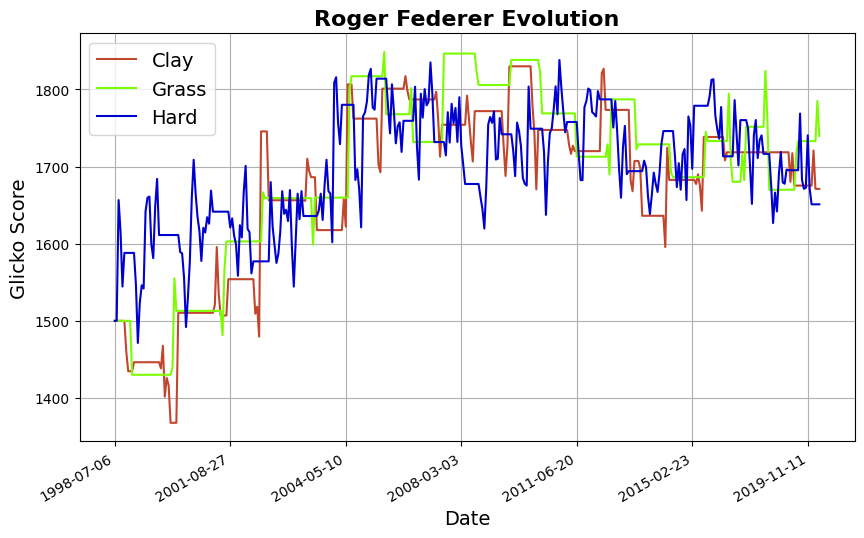

In [68]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = ["#C2452D", "#7CFC00", "#0000D1"]

for i, c in enumerate(colors):
    ax.plot(federer_evolution["Date"].to_numpy(), np.array(federer_glickos)[:, i],
            linewidth = 1.5, color = c, label = list(surface_dict.keys())[i])

ax.xaxis.set_major_locator(mdates.DayLocator(interval = 60))
fig.autofmt_xdate()
ax.grid(True)

format_plot(ax, xlab = "Date", ylab = "Glicko Score", title = "Roger Federer Evolution", legend = True)

plt.savefig("imgs/federer_evolution")
plt.show()

In [69]:
processed_df.drop(columns = ["Date", "Tourney", "Location", "Player1", "Player2",
                              "Player1Nationality", "Player2Nationality",
                             "Player1SetsWon", "Player1SetsLost", "Surface", "StartDate",
                             "Player1GamesWon", "Player1GamesLost",
                             "Player1Glicko", "Player2Glicko"], inplace = True)


columns_final_order = ["BestOf", "Player1TournamentMinutesPlayed", "Player2TournamentMinutesPlayed", "GlickoDiff", "Player1Age", "Player1PlaysHome", "Player2Age", "Player2PlaysHome", "Player1Won"]

processed_df = processed_df.reset_index()[columns_final_order]
display(processed_df)

,BestOf,Player1TournamentMinutesPlayed,Player2TournamentMinutesPlayed,GlickoDiff,Player1Age,Player1PlaysHome,Player2Age,Player2PlaysHome,Player1Won
0,3,0.0,0.0,0.000000,0.973077,False,0.853846,False,0.0
1,3,111.0,0.0,0.000000,0.853846,False,0.726923,False,1.0
2,3,111.0,0.0,0.000000,0.726923,False,0.780769,False,1.0
3,3,0.0,0.0,0.000000,0.961538,False,0.884615,False,0.0
4,3,0.0,0.0,0.000000,0.919231,False,0.815385,False,0.0
...,...,...,...,...,...,...,...,...,...
92776,5,143.0,0.0,-39.061611,0.800000,False,0.746154,True,1.0
92777,5,316.0,0.0,79.768684,0.784615,False,0.780769,False,1.0
92778,5,150.0,0.0,-171.785465,0.984615,False,0.688462,False,1.0
92779,5,0.0,409.0,-207.429665,0.957692,False,0.980769,False,0.0


In [70]:
# Initial split: 70-15-15

# df_train = processed_df.sample(frac = 0.7, random_state = 200) #random state is a seed value
indexes_last = range(int(len(processed_df) * 8 / 10.0), len(processed_df))
indexes_first = range(int(len(processed_df) * 1 / 10.0))
df_train = processed_df.drop(indexes_last).drop(indexes_first)
val_and_test = processed_df.drop(df_train.index).drop(indexes_first)
#df_val = val_and_test.sample(frac = 0.5, random_state = 200)
#df_test = val_and_test.drop(df_val.index)

df_test = val_and_test

### NAIVE BAYES

In [71]:
from sklearn.naive_bayes import GaussianNB

y_train = df_train["Player1Won"]
x_train = df_train.drop(columns = ["Player1Won"])
#display(x_train)
gnb = GaussianNB()
trained_gnb = gnb.fit(x_train, y_train)
y_pred = trained_gnb.predict(x_train)
y_proba = trained_gnb.predict_proba(x_train)

print("Number of mislabeled points out of a total %d points : %d" \
      % (x_train.shape[0], (y_train != y_pred).sum()))

print(f"Accuracy: {(y_train == y_pred).sum() / (len(y_train))}")
# for pred, act, prob in zip(y_pred, y_train, y_proba):
#     if pred != act:
#         print(f"Misclassified as {pred} with proba: {prob[0]}")

print(f"1.0 preds: {(y_train == 1.0).sum()}, 0.0 preds: {(y_train == 0.0).sum()}")

Number of mislabeled points out of a total 64946 points : 14942
Accuracy: 0.7699319434607212
1.0 preds: 32607, 0.0 preds: 32339


In [72]:
#What is this doing?
count = 0
for prob, pred, act in zip(y_proba, y_pred, y_train):
    if pred != act and prob[0] < 0.6 and prob[0] > 0.4:
        count += 1
print(count / len(y_pred))

0.10250053890924768


In [73]:
y_test = df_test["Player1Won"]
x_test = df_test.drop(columns = ["Player1Won"])
y_train = df_train["Player1Won"]
x_train = df_train.drop(columns = ["Player1Won"])

#display(x_test)
# y_pred = trained_gnb.predict(x_test)
# y_proba = trained_gnb.predict_proba(x_test)

# print("Number of mislabeled points out of a total %d points : %d" \
#       % (x_test.shape[0], (y_test != y_pred).sum()))

# print(f"Accuracy: {(y_test == y_pred).sum() / (len(y_test))}")


### LOGISTIC REGRESSION

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import warnings
#A bunch of unnecessary warnings as function does not converge with 10k iterations
warnings.filterwarnings("ignore")
#Parameters being changed
params_LR = {"penalty" : ["none", "l2",'l1','elasticnet'],
             'solver' : ["lbfgs", 'liblinear', 'newton-cg', 'newton-cholesky','sag' 'saga'], 
             'max_iter' : [1,10,100,1000]}
val = 0
LR_output = pd.DataFrame({"Algorithm" : "LogisticRegression",
                          "Param Change" : "Default",
                          "Train Accuracy" : val,
                          "Test Accuracy" : val}, index=[0])
#Deafault Parameters: Penalty = l2, solver = saga, l1_ratio =0.5, max_ter=10000, variables change based on which analysis
for p in params_LR["penalty"]:
    
    clf = LogisticRegression(penalty=p, solver = "saga", l1_ratio= 0.5).fit(x_train, y_train)
    y_pred_train = clf.predict(x_train)
    y_pred_test = clf.predict(x_test)
    LR_output.loc[len(LR_output.index)] = ["LogisticRegression", p, accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)]

for s in params_LR["solver"]:
    
    clf = LogisticRegression(penalty='l2', l1_ratio= 0.5).fit(x_train, y_train)
    y_pred_train = clf.predict(x_train)
    y_pred_test = clf.predict(x_test)
    LR_output.loc[len(LR_output.index)] = ["LogisticRegression", s, accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)]
 
for iter in params_LR['max_iter']:
    clf = LogisticRegression(penalty='l2', solver='saga', l1_ratio= 0.5, max_iter = iter).fit(x_train, y_train)
    y_pred_train = clf.predict(x_train)
    y_pred_test = clf.predict(x_test)
    LR_output.loc[len(LR_output.index)] = ["LogisticRegression", ("Num Iters:" +str(iter)), accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)]

display(LR_output)


#print(f"LR Score on Train set: {clf.score(x_train, y_train)}")




,Algorithm,Param Change,Train Accuracy,Test Accuracy
0,LogisticRegression,Default,0.000000,0.000000
1,LogisticRegression,none,0.800465,0.784340
2,LogisticRegression,l2,0.800465,0.784340
3,LogisticRegression,l1,0.800480,0.784340
4,LogisticRegression,elasticnet,0.800465,0.784340
5,LogisticRegression,lbfgs,0.800881,0.784232
6,LogisticRegression,liblinear,0.800881,0.784232
7,LogisticRegression,newton-cg,0.800881,0.784232
8,LogisticRegression,newton-cholesky,0.800881,0.784232
9,LogisticRegression,sagsaga,0.800881,0.784232


### RANDOM FOREST

In [76]:
from sklearn.ensemble import RandomForestClassifier
params_RF = {"n_estimators" : [1,10,100,1000],
             "max_depth" : [1,10,100],
             "min_samples_leaf" : [1,10,100],
             "max_features" : [1,10,100]}
RF_output = pd.DataFrame({"Algorithm" : "RandomForest",
                          "Param Change" : "Default",
                          "Train Accuracy" : val,
                          "Test Accuracy" : val}, index=[0])

#Random Forest Default Vals: n_estimators: 100, max_depth = none, min_samples_leaf = 1, max_features=n_features(num of features in fit)
for n in params_RF["n_estimators"]:
    rfr = RandomForestClassifier(n_estimators=n)
    rfr.fit(x_train,y_train)
    y_pred_train = rfr.predict(x_train)
    y_pred_test = rfr.predict(x_test)
    RF_output.loc[len(RF_output.index)] = ["RandomForest", ("Num Estimators="+str(n)), accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)]
for d in params_RF["max_depth"]:
    rfr = RandomForestClassifier(max_depth=d)
    rfr.fit(x_train,y_train)
    y_pred_train = rfr.predict(x_train)
    y_pred_test = rfr.predict(x_test)
    RF_output.loc[len(RF_output.index)] = ["RandomForest", ("Depth="+str(d)), accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)]

for l in params_RF["min_samples_leaf"]:
    rfr = RandomForestClassifier(min_samples_leaf=l)
    rfr.fit(x_train,y_train)
    y_pred_train = rfr.predict(x_train)
    y_pred_test = rfr.predict(x_test)
    RF_output.loc[len(RF_output.index)] = ["RandomForest", ("Min Leaf Samples="+str(l)), accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)]

for f in params_RF["max_features"]:
    rfr = RandomForestClassifier(max_features=f)
    rfr.fit(x_train,y_train)
    y_pred_train = rfr.predict(x_train)
    y_pred_test = rfr.predict(x_test)
    RF_output.loc[len(RF_output.index)] = ["RandomForest", ("Num Features="+str(f)), accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)]

display(RF_output)



,Algorithm,Param Change,Train Accuracy,Test Accuracy
0,RandomForest,Default,0.000000,0.000000
1,RandomForest,Num Estimators=1,0.903812,0.729051
2,RandomForest,Num Estimators=10,0.986928,0.766773
3,RandomForest,Num Estimators=100,0.999985,0.774640
4,RandomForest,Num Estimators=1000,1.000000,0.775718
5,RandomForest,Depth=1,0.771903,0.759929
6,RandomForest,Depth=10,0.815708,0.785472
7,RandomForest,Depth=100,0.999985,0.774640
8,RandomForest,Min Leaf Samples=1,0.999985,0.776095
9,RandomForest,Min Leaf Samples=10,0.831398,0.784933


In [77]:
print("Training Score: ", rfr.score(x_train, y_train))
print("Testing Score: ", rfr.score(x_test, y_test))

#print(f"Accuracy: {(y_test == predictions).sum() / (len(y_test))}")

Training Score:  0.9999846025929233
Testing Score:  0.7722153365306892


In [78]:
y_pred = clf.predict(x_test)
y_proba = clf.predict_proba(x_test)

certainty_bins = [0.55, 0.70, 0.85, 1]
certainty_bins_labs = ["< 0.55", "0.55 - 0.70", "0.70 - 0.85", "> 0.85"]
misclass_counts = np.zeros((2, 4))

for pred, act, prob in zip(y_pred, y_test, y_proba):
    idx_row = 0 if pred == act else 1
    idx_col = 0
    
    if max(prob) > certainty_bins[2]:
        idx_col = 3
    elif max(prob) > certainty_bins[1]:
        idx_col = 2
    elif max(prob) > certainty_bins[0]:
        idx_col = 1
    
    misclass_counts[idx_row, idx_col] += 1
        


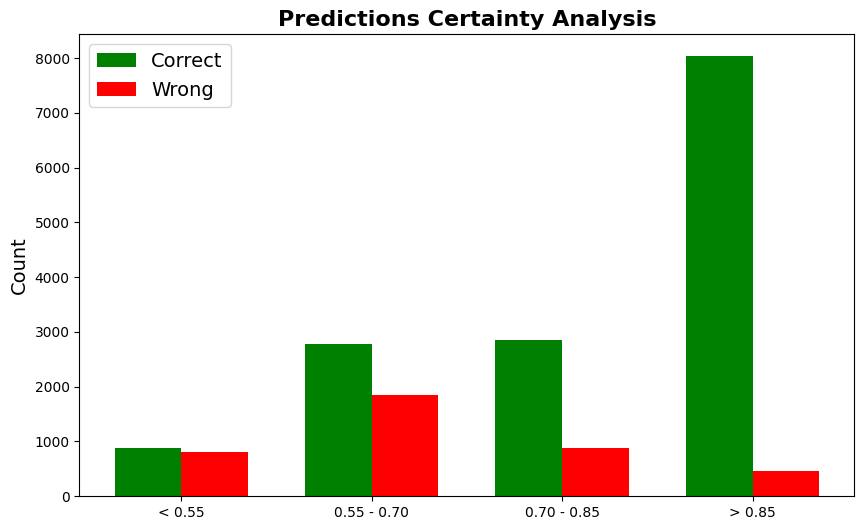

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

width = 0.35  # the width of the bars
x = np.arange(len(certainty_bins_labs))  # the label locations

ax.bar(x - width/2, misclass_counts[0, :], width, color = "g", label = 'Correct')
ax.bar(x + width/2, misclass_counts[1, :], width, color = "r", label = 'Wrong')

format_plot(ax, xlab = "", ylab = "Count", title = "Predictions Certainty Analysis", legend = True)

plt.xticks(x, certainty_bins_labs)
plt.savefig("imgs/pred_certainty")

plt.show()